## Import Libraries

In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn import metrics, linear_model
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, make_scorer, confusion_matrix, precision_recall_curve, roc_curve, precision_recall_curve, make_scorer, f1_score, classification_report
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import det_curve, DetCurveDisplay
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

import warnings

In [2]:
# Define the default value of constants here
ANOMALY_RATIO = 0.01

## Load data from file

In [3]:
#Surpass Warnings
warnings.filterwarnings('ignore')

# Load file from Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Surpass Warnings
warnings.filterwarnings('ignore')

# Load file from Google drive
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/3253-Machine-Learning/Project/dataset_labeled.csv')

# Drop the unused columns
if 'Unnamed: 0' in df:
  df.drop('Unnamed: 0', axis=1, inplace=True)

# Parse date string into datetime format
df["timestamp"]= pd.to_datetime(df["timestamp"])

# Use timestamp at the main index of the data frame
df=df.set_index('timestamp').reset_index()

df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   10320 non-null  datetime64[ns]
 1   value       10320 non-null  int64         
 2   is_anomaly  10320 non-null  int64         
 3   comment     343 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 322.6+ KB


## Extract Features

In [5]:
# Extract features from timestamp

df["hour"]=df.timestamp.dt.hour

df["minute"]=df.timestamp.dt.minute

df["weekday"]=pd.Categorical(df.timestamp.dt.strftime('%A'), categories=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])

df['day']=df.timestamp.dt.weekday

# Combine hour and minute
df["hour_minute"]=df.timestamp.dt.hour*100 + df.timestamp.dt.minute

# Add Lag features
df["value_lag1D"] = df['value'].shift(48) # 1 day = 48 * 30 min
df["value_lag1D"] = df["value_lag1D"].fillna(0)
df["value_lag2D"] = df['value'].shift(96) # 2 day = 96 * 30 min
df["value_lag2D"] = df["value_lag2D"].fillna(0)
df["value_lag7D"] = df['value'].shift(336) # 2 day = 336 * 30 min
df["value_lag7D"] = df["value_lag7D"].fillna(0)

# Add rolling window features
df["value_rolling_mean"] = df['value'].rolling(window=2).mean()
df["value_rolling_mean"] = df["value_rolling_mean"].fillna(0)

df["value_rolling_min"] = df['value'].rolling(window=2).min()
df["value_rolling_min"] = df["value_rolling_min"].fillna(0)

df["value_rolling_max"] = df['value'].rolling(window=2).max()
df["value_rolling_max"] = df["value_rolling_max"].fillna(0)


In [6]:
# Set the target
df['is_anomaly'] = df['is_anomaly'].astype(int)
df['is_anomaly'] = df['is_anomaly'].replace(1, -1).replace(2, -1).replace(0,1)

## Explore the data

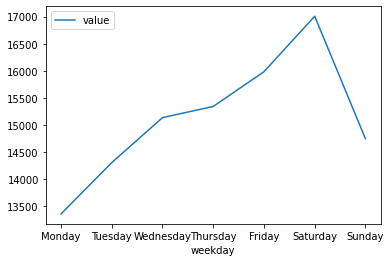

In [7]:
df[["value", "weekday"]].groupby('weekday').mean().plot()

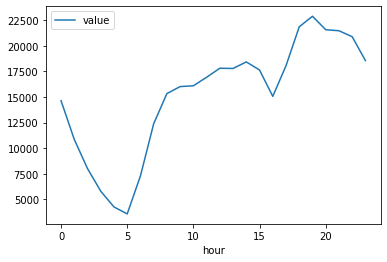

In [8]:
df[["value", "hour"]].groupby('hour').mean().plot()

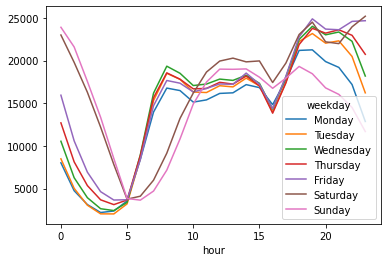

In [9]:
df.groupby(['hour','weekday']).mean()['value'].unstack().plot()

In [10]:
df.groupby(['hour','weekday'])['value'].mean()

hour  weekday  
0     Monday        8020.283333
      Tuesday       8483.709677
      Wednesday    10544.661290
      Thursday     12698.500000
      Friday       15941.048387
                       ...     
23    Wednesday    18186.274194
      Thursday     20732.241935
      Friday       24668.693548
      Saturday     25192.516129
      Sunday       11686.450000
Name: value, Length: 168, dtype: float64

In [11]:
df_final = df.join(df.groupby(['minute', 'hour','weekday'])['value'].mean(),on=['minute', 'hour','weekday'],rsuffix='_avg')

In [12]:
# Estimate the anomaly ratio
anomaly_count = len(df_final[df_final['is_anomaly']==-1])
total_count = len(df_final)
ANOMALY_RATIO = anomaly_count/total_count
print("ANOMALY_RATIO:", ANOMALY_RATIO)

ANOMALY_RATIO: 0.033236434108527134


In [13]:
df_clean_1 = df_final[(df_final['timestamp']>='2014-07-16 00:00:00') & (df_final['timestamp']<'2014-08-30 00:00:00')]
df_clean_2 = df_final[(df_final['timestamp']>='2014-09-23 00:00:00') & (df_final['timestamp']<'2014-11-01 00:00:00')]
df_clean_3 = df_final[(df_final['timestamp']>='2014-11-05 00:00:00') & (df_final['timestamp']<'2014-11-22 00:00:00')]
df_clean_4 = df_final[(df_final['timestamp']>='2015-01-03 00:00:00') & (df_final['timestamp']<'2015-01-25 00:00:00')]
df_final_clean=pd.concat([df_clean_1, df_clean_2, df_clean_3, df_clean_4])

In [14]:
X_clean = df_final_clean[['value',
              #'value_lag1D',
              #'value_lag2D',
              #'value_lag7D',
              'value_rolling_mean',
              'value_rolling_min',
              'value_rolling_max',
              'minute',
              'hour',
              'day']]

X = df_final[['value',
              #'value_lag1D',
              #'value_lag2D',
              #'value_lag7D',
              'value_rolling_mean',
              'value_rolling_min',
              'value_rolling_max',
              'minute',
              'hour',
              'day']]

y = df_final['is_anomaly']

# Remove the first 336 data point because they lack rolling and lagging values
X=X[336:]
y=y[336:]
df_final=df_final[336:]

X=X.reset_index().drop(['index'], axis=1)
y=y.reset_index().drop(['index'], axis=1)
df_final=df_final.reset_index().drop(['index'], axis=1)

In [15]:
df_final

,timestamp,value,is_anomaly,comment,hour,minute,weekday,day,hour_minute,value_lag1D,value_lag2D,value_lag7D,value_rolling_mean,value_rolling_min,value_rolling_max,value_avg
0,2014-07-08 00:00:00,9292,1,NaN,0,0,Tuesday,1,0,8675.0,15427.0,10844.0,10570.5,9292.0,11849.0,9636.129032
1,2014-07-08 00:30:00,8110,1,NaN,0,30,Tuesday,1,30,7180.0,14615.0,8127.0,8701.0,8110.0,9292.0,7331.290323
2,2014-07-08 01:00:00,7352,1,NaN,1,0,Tuesday,1,100,5178.0,13124.0,6210.0,7731.0,7352.0,8110.0,5740.354839
3,2014-07-08 01:30:00,5049,1,NaN,1,30,Tuesday,1,130,3658.0,12222.0,4656.0,6200.5,5049.0,7352.0,4316.032258
4,2014-07-08 02:00:00,3451,1,NaN,2,0,Tuesday,1,200,3181.0,11134.0,3820.0,4250.0,3451.0,5049.0,3440.032258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9979,2015-01-31 21:30:00,24670,1,NaN,21,30,Saturday,5,2130,26432.0,23188.0,21588.0,24194.5,23719.0,24670.0,22255.774194
9980,2015-01-31 22:00:00,25721,1,NaN,22,0,Saturday,5,2200,26739.0,22638.0,24357.0,25195.5,24670.0,25721.0,23309.193548
9981,2015-01-31 22:30:00,27309,1,NaN,22,30,Saturday,5,2230,26874.0,21501.0,25009.0,26515.0,25721.0,27309.0,24590.709677
9982,2015-01-31 23:00:00,26591,1,NaN,23,0,Saturday,5,2300,26928.0,20719.0,25641.0,26950.0,26591.0,27309.0,25064.709677


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [17]:
# Scale the features
stdScaler = StandardScaler()
X_train_scaled = stdScaler.fit_transform(X_train)
X_test_scaled = stdScaler.transform(X_test)
X_scaled = stdScaler.transform(X)

# Scale the clean sub dataset
X_clean_scaled = stdScaler.transform(X_clean)

In [18]:
model = OneClassSVM()
param_grid = {'kernel': ['rbf'], 'gamma': [0.5, 0.6], 'nu':[0.033]}
grid_search = GridSearchCV(model, 
                          param_grid,
                          scoring='roc_auc',
                          refit=True,
                          cv=10, 
                          return_train_score=True)

now = datetime.now()
print('GridSearchCV Start Time:', now)

#Train with the clean dataset
best_model = grid_search.fit(X_clean_scaled)

now = datetime.now()
print('GridSearchCV End Time:', now)

print('Optimum parameters', best_model.best_params_)

GridSearchCV Start Time: 2022-12-01 15:03:21.753808
GridSearchCV End Time: 2022-12-01 15:03:27.192763
Optimum parameters {'gamma': 0.5, 'kernel': 'rbf', 'nu': 0.033}


In [19]:
# Predict the anomalies
y_predict_test = best_model.predict(X_test_scaled)
y_predict_all = best_model.predict(X_scaled)

# Calculate the anomaly scores
y_scores_test = best_model.decision_function(X_test_scaled)
y_scores_all = best_model.decision_function(X_scaled)

              precision    recall  f1-score   support

          -1       0.28      0.56      0.38       329
           1       0.98      0.95      0.97      9655

    accuracy                           0.94      9984
   macro avg       0.63      0.76      0.67      9984
weighted avg       0.96      0.94      0.95      9984

Number of data points in test data set: 9984
Number of anomalies in test data set: 648
Accuracy_All: 0.9390024038461539


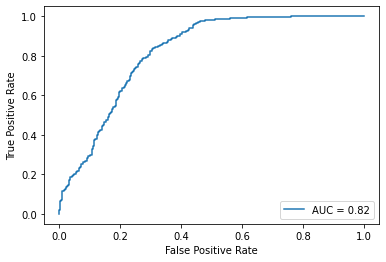

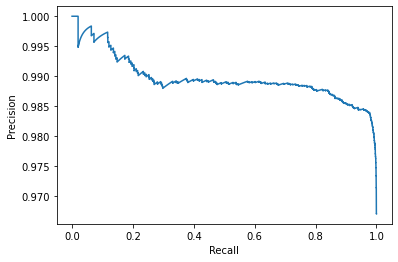

In [20]:
precision, recall, thresholds = precision_recall_curve(y, y_scores_all)

# Plot Confusion Matrix
#cm = confusion_matrix(y, y_predict_all)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#disp.plot()

# Plot RoC
fpr, tpr, _ = roc_curve(y, y_scores_all)
roc_auc = metrics.auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

#Plot Precision Recall
prec, recall, _ = precision_recall_curve(y, y_scores_all)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

print(classification_report(y, y_predict_all))

s = pd.Series(y_predict_all)
print("Number of data points in test data set:", len(s))
print("Number of anomalies in test data set:", len(s[s < 1]))
print("Accuracy_All:", accuracy_score(y, y_predict_all))

SCORE_THREHOLD: -0.09367059730715922


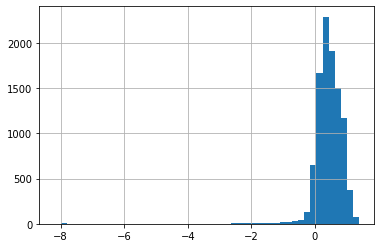

In [21]:
# Add score column
df_final['score']=y_scores_all
df_final['predict']=y_predict_all

# Estimate the score threhold. Data points lower than this are anomalies
ANOMALY_RATIO_FACTOR = 1.2 # for adjusting the therhold
SCORE_THREHOLD = df_final['score'].quantile(ANOMALY_RATIO * ANOMALY_RATIO_FACTOR)
print("SCORE_THREHOLD:", SCORE_THREHOLD)
df_final['score'].hist(bins=50)

# Add outlier column
df_final['score_outliers']   = pd.Series(y_scores_all).apply(lambda a:1 if(a < SCORE_THREHOLD) else 0)
df_final['predict_outliers'] = pd.Series(y_predict_all).apply(lambda a:1 if(a < 0) else 0)

# Get all types of anomalies. 
# 1. True anomalies
true_anomaly = df_final[df_final["is_anomaly"]==-1]

# 2. Predicted anomalies
predicted_anomaly_index = np.where(y_predict_all < 0)
predicted_anomaly = df_final[df_final.index.isin(predicted_anomaly_index[0])]

# 3. Score based anomalies
score_based_anomaly_index = np.where(y_scores_all < SCORE_THREHOLD)
score_based_anomaly = df_final[df_final.index.isin(score_based_anomaly_index[0])]

In [22]:
def plot(plt, title):
  plt.figure(figsize=(19,5))
  plt.ylabel('Totoal number of requests')
  plt.xlabel('Time')
  plt.ylim(ymin=y_min, ymax=y_max)
  plt.xlim(xmin=start_date, xmax=end_date)
  plt.plot(df_final['timestamp'], df_final['value'], label='Number of requests')
  plt.plot(df_final['timestamp'], df_final['score']*SCALE, linestyle=(0, (1, 1)), color='b', label='Anomaly score give by decision function')
  plt.plot(true_anomaly['timestamp'], true_anomaly['value'], "bo", label="Labeled anomalies")
  plt.plot(score_based_anomaly['timestamp'], score_based_anomaly['value'], "rx", label="Predicted anomalies")
  plt.axhline(y=SCORE_THREHOLD*SCALE, color='b', linestyle='-')
  plt.eventplot(score_based_anomaly['timestamp'],lineoffsets=10000,linelengths=200000,color='r', alpha=0.1)
  plt.title(title)
  plt.legend()


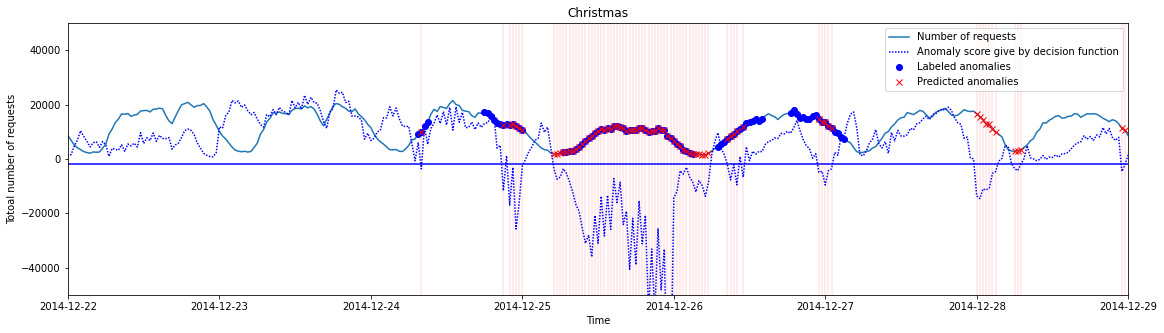

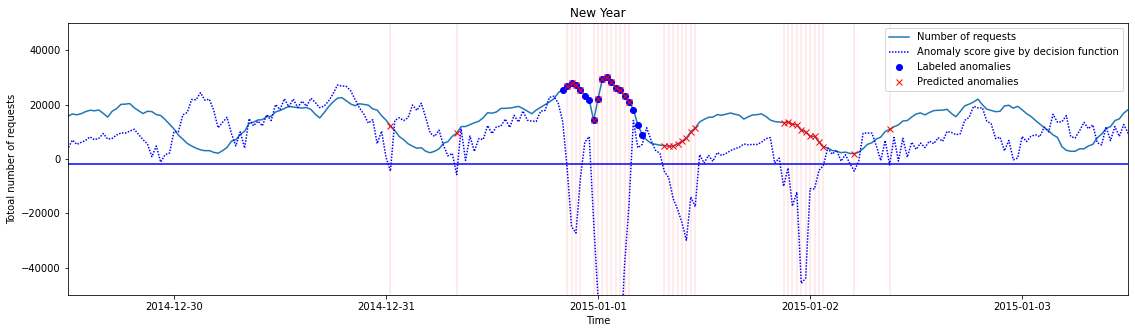

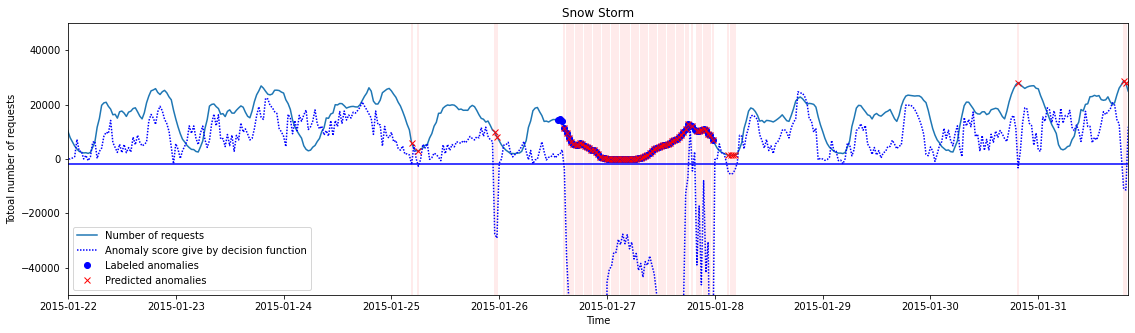

In [23]:
y_min=-50000
y_max=50000
SCALE=20000

# Selected detected anomalies here

# Christmas
start_date = datetime.strptime("2014-12-22 0", '%Y-%m-%d %H')
end_date = datetime.strptime("2014-12-29 0", '%Y-%m-%d %H')
plot(plt, "Christmas")

# New year
start_date = datetime.strptime("2014-12-29 12", '%Y-%m-%d %H')
end_date = datetime.strptime("2015-01-03 12", '%Y-%m-%d %H')
plot(plt, "New Year")

# Snow storm
start_date = datetime.strptime("2015-01-22 0", '%Y-%m-%d %H')
end_date = datetime.strptime("2015-01-31 20", '%Y-%m-%d %H')
plot(plt, "Snow Storm")

In [24]:
fig = px.histogram(df_final,x='score',color='score_outliers')
fig.show()

In [25]:

fig = px.scatter(df_final.reset_index(), x='timestamp', y='value', color="score_outliers",title="NYC Taxi Demand")
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

In [26]:
fig = px.scatter(df_final.reset_index(), x='timestamp', y='value', color="is_anomaly",title="NYC Taxi Demand")
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

In [27]:
fig = px.scatter(df_final.reset_index(), x='timestamp', y='value', color="predict_outliers",title="NYC Taxi Demand")
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

In [28]:
df_final

,timestamp,value,is_anomaly,comment,hour,minute,weekday,day,hour_minute,value_lag1D,value_lag2D,value_lag7D,value_rolling_mean,value_rolling_min,value_rolling_max,value_avg,score,predict,score_outliers,predict_outliers
0,2014-07-08 00:00:00,9292,1,NaN,0,0,Tuesday,1,0,8675.0,15427.0,10844.0,10570.5,9292.0,11849.0,9636.129032,0.589673,1,0,0
1,2014-07-08 00:30:00,8110,1,NaN,0,30,Tuesday,1,30,7180.0,14615.0,8127.0,8701.0,8110.0,9292.0,7331.290323,0.558859,1,0,0
2,2014-07-08 01:00:00,7352,1,NaN,1,0,Tuesday,1,100,5178.0,13124.0,6210.0,7731.0,7352.0,8110.0,5740.354839,0.769858,1,0,0
3,2014-07-08 01:30:00,5049,1,NaN,1,30,Tuesday,1,130,3658.0,12222.0,4656.0,6200.5,5049.0,7352.0,4316.032258,0.775575,1,0,0
4,2014-07-08 02:00:00,3451,1,NaN,2,0,Tuesday,1,200,3181.0,11134.0,3820.0,4250.0,3451.0,5049.0,3440.032258,1.027448,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9979,2015-01-31 21:30:00,24670,1,NaN,21,30,Saturday,5,2130,26432.0,23188.0,21588.0,24194.5,23719.0,24670.0,22255.774194,0.764580,1,0,0
9980,2015-01-31 22:00:00,25721,1,NaN,22,0,Saturday,5,2200,26739.0,22638.0,24357.0,25195.5,24670.0,25721.0,23309.193548,0.715164,1,0,0
9981,2015-01-31 22:30:00,27309,1,NaN,22,30,Saturday,5,2230,26874.0,21501.0,25009.0,26515.0,25721.0,27309.0,24590.709677,0.471007,1,0,0
9982,2015-01-31 23:00:00,26591,1,NaN,23,0,Saturday,5,2300,26928.0,20719.0,25641.0,26950.0,26591.0,27309.0,25064.709677,0.235742,1,0,0
